<a href="https://colab.research.google.com/github/vkk1710/System-of-silicone/blob/master/leaf_localisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 34kB/s 


In [9]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import zipfile
import shutil

In [27]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import keras

In [23]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
zip_ref = zipfile.ZipFile('/content/PlantDoc cropped.zip', 'r')
zip_ref.extractall("/content")
zip_ref.close()
os.remove('/content/PlantDoc cropped/annotations/test/classes.txt')
shutil.move('/content/PlantDoc cropped/annotations/train/classes.txt','/content/classes.txt')

In [ ]:
len(os.listdir('/content/PlantDoc cropped/annotations/train'))

In [ ]:
train_img = '/content/PlantDoc cropped/train'
test_img = '/content/PlantDoc cropped/test'
train_anno = '/content/PlantDoc cropped/annotations/train'
test_anno = '/content/PlantDoc cropped/annotations/test'

In [ ]:
def resize(dire,inp_shape):
  for i in tqdm(os.listdir(dire)):
    img = cv2.imread(os.path.join(dire,i))
    img = cv2.resize(img,inp_shape,interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join(dire,i),img)

In [ ]:
def hor_flip_box(dire):
  for i in tqdm(os.listdir(dire)):
    k=[]
    file = open(os.path.join(dire,i),'r')
    file1 = open(os.path.join(dire,'lr__'+i),'w')    ##.split('.')[0]+'_lr'+'.txt'
    s = file.readlines()
    #print(i)
    #print('s:',s)
    k = s[0].split(' ') 
    #print('k:',k)
    k[1] = str(round(1-float(k[1]),6))
    file1.write(' '.join(k)) 
    file.close()
    file1.close()
def hor_flip(dire):
  for i in tqdm(os.listdir(dire)):
    img = cv2.imread(os.path.join(dire,i))
    imgc = cv2.flip(img,1) 
    cv2.imwrite(os.path.join(dire,'lr__'+i),imgc)

In [ ]:
def ver_flip_box(dire):
  for i in tqdm(os.listdir(dire)):
    k=[]
    file = open(os.path.join(dire,i),'r')
    file1 = open(os.path.join(dire,'ud__'+i),'w')    ##.split('.')[0]+'_ud'+'.txt'
    s = file.readlines()
    #print(i)
    #print('s:',s)
    k = s[0].split(' ') 
    #print('k:',k)
    k[2] = str(round(1-float(k[2]),6))
    file1.write(' '.join(k)) 
    file.close()
    file1.close()
def ver_flip(dire):
  for i in tqdm(os.listdir(dire)):
    img = cv2.imread(os.path.join(dire,i))
    imgc = cv2.flip(img,0) 
    cv2.imwrite(os.path.join(dire,'ud__'+i),imgc)

In [ ]:
ver_flip(train_img)
ver_flip_box(train_anno)
ver_flip(test_img)
ver_flip_box(test_anno)

100%|██████████| 68/68 [00:00<00:00, 5959.81it/s]


In [ ]:
hor_flip(train_img)
hor_flip_box(train_anno)
hor_flip(test_img)
hor_flip_box(test_anno)

100%|██████████| 136/136 [00:00<00:00, 7862.84it/s]


In [ ]:
len(os.listdir('/content/PlantDoc cropped/annotations/test'))

272

In [ ]:
resize(train_img,(224,224))
resize(test_img,(224,224))

100%|██████████| 272/272 [00:00<00:00, 305.87it/s]


In [ ]:
anntr = sorted(os.listdir(train_anno))
imgtr = sorted(os.listdir(train_img))
annte = sorted(os.listdir(test_anno))
imgte = sorted(os.listdir(test_img))

In [ ]:
X_tr = []
X_te = []
y_tr_cl = []
y_tr_bx = []
y_te_cl = []
y_te_bx = []
for i in tqdm(imgtr):
   X_tr.append(cv2.imread(os.path.join(train_img,i)))
for i in tqdm(imgte):
   X_te.append(cv2.imread(os.path.join(test_img,i)))
for i in tqdm(anntr):
  k=[]
  file = open(os.path.join(train_anno,i),'r')   
  s = file.read().splitlines()
  k = list(map(lambda x:float(x),s[0].split(' ')))
  y_tr_cl.append(k[0:1])
  y_tr_bx.append(k[1:])
  file.close()
for i in tqdm(annte):
  k=[]
  file = open(os.path.join(test_anno,i),'r')   
  s = file.read().splitlines()
  k = list(map(lambda x:float(x),s[0].split(' ')))
  y_te_cl.append(k[0:1])
  y_te_bx.append(k[1:])
  file.close()  

100%|██████████| 272/272 [00:00<00:00, 20435.83it/s]


In [ ]:
x_tr = np.array(X_tr)
x_te = np.array(X_te)
x_tr = x_tr/255.0
x_te = x_te/255.0
y_tr_cl = np.array(y_tr_cl)
y_tr_bx = np.array(y_tr_bx)
y_te_cl = np.array(y_te_cl)
y_te_bx = np.array(y_te_bx)

In [29]:
model = VGG19(include_top=False,classes=4,weights=None,input_shape=(224,224,3))
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [30]:
model = VGG16(classes=4,weights=None,input_shape=(224,224,3),include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
model.outputs[0]

<tf.Tensor 'block5_pool_3/Identity:0' shape=(None, 7, 7, 512) dtype=float32>

In [31]:
flat1 = Flatten()(model.outputs[0])
dense1 = Dense(4096, activation='relu')(flat1)
dense2 = Dense(4096, activation='relu')(dense1)
class_out = Dense(2,activation='softmax',name="class_output")(dense2)
box_out = Dense(4,name="box_output")(dense2)
model = Model(inputs=model.inputs, outputs=[class_out,box_out])

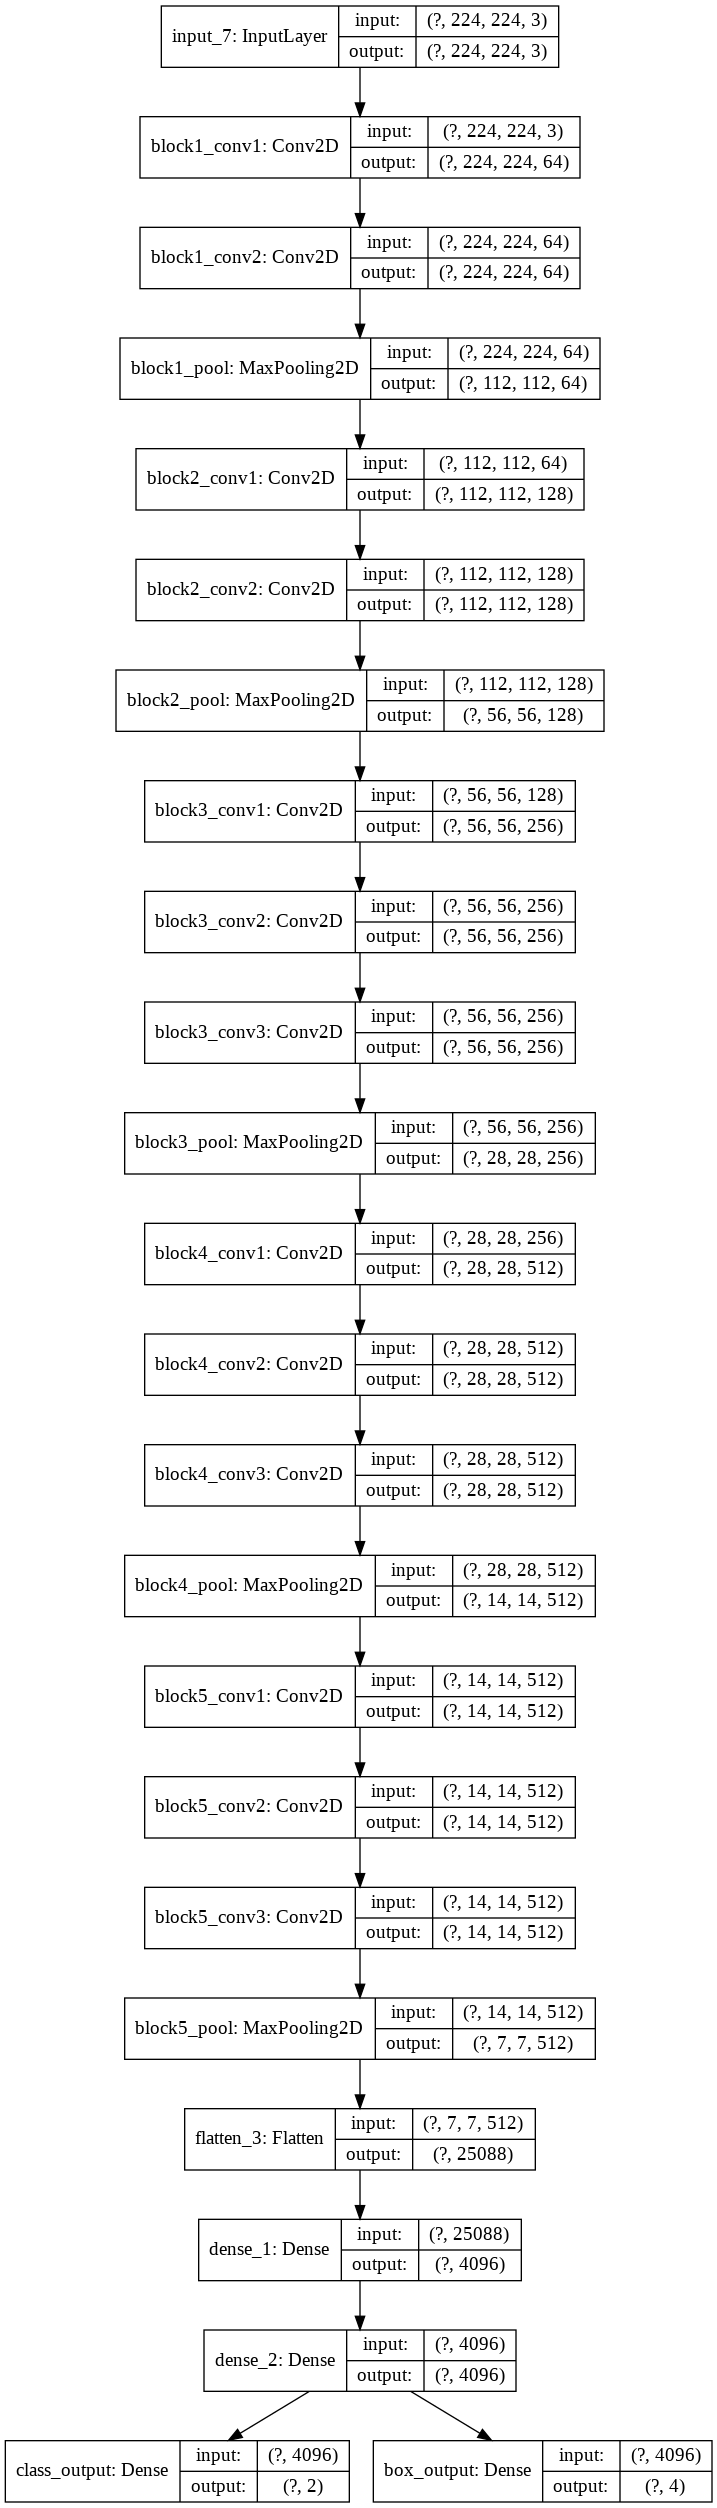

In [32]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [34]:
model.compile(
    optimizer= keras.optimizers.RMSprop(1e-3),
    loss={
        "box_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.SparseCategoricalCrossentropy(),
    },
    metrics={
        "box_output": [
            keras.metrics.MeanAbsoluteError()
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

In [ ]:
history = model.fit(x_tr, y_tr_bx, batch_size=4, epochs=15,validation_data=(x_te, y_te_bx))

Epoch 1/15
1000/1000 [==============================] - 286s 286ms/step - loss: 0.0328 - mean_absolute_percentage_error: 13.4899 - mean_absolute_error: 0.0918 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 9.1277 - val_mean_absolute_error: 0.0624
Epoch 2/15
1000/1000 [==============================] - 284s 284ms/step - loss: 0.0065 - mean_absolute_percentage_error: 8.1457 - mean_absolute_error: 0.0559 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 9.1196 - val_mean_absolute_error: 0.0574
Epoch 3/15
1000/1000 [==============================] - 284s 284ms/step - loss: 0.0062 - mean_absolute_percentage_error: 7.9047 - mean_absolute_error: 0.0543 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 8.4430 - val_mean_absolute_error: 0.0562
Epoch 4/15
1000/1000 [==============================] - 284s 284ms/step - loss: 0.0062 - mean_absolute_percentage_error: 7.8273 - mean_absolute_error: 0.0539 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 8.8640 - val_mea

In [ ]:
history.history['box_output_loss']

[0.0055927187, 0.005592715, 0.0055821678, 0.0055863135]

In [ ]:
history.history['val_box_output_loss']

[0.00779822189360857,
 0.007362463977187872,
 0.007321380078792572,
 0.007500260137021542]

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['box_output_loss'], color='b', label="Training loss")
ax1.plot(history.history['val_box_output_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 4, 1))
ax1.set_yticks(np.arange(0, 0.01, 0.005))
 
#ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
#ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
#ax2.set_xticks(np.arange(1, 15, 1))
 
#legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# **testing**

In [ ]:
#os.mkdir('/content/testimg')
shutil.move('/content/pot1.jpeg','/content/testimg/pot1.jpeg')

'/content/testimg/pot1.jpeg'

In [ ]:
os.remove('/content/testimg/pot2.jpg')

In [ ]:
os.listdir('/content/testimg')

['pot1.jpeg']

In [ ]:
resize('/content/testimg',(224,224))
xtest=[]
for i in tqdm(os.listdir('/content/testimg')):
  img = cv2.imread(os.path.join('/content/testimg',i))
  xtest.append(img)
xtest = np.array(xtest)/255.0

100%|██████████| 1/1 [00:00<00:00, 271.00it/s]


In [ ]:
 ypr = model.predict(xtest,batch_size=1)

In [ ]:
ypr[1]

array([[0.49312115, 0.4969399 , 0.8833267 , 0.90284914]], dtype=float32)

In [ ]:
y_tr_bx

array([[0.475352, 0.500921, 0.880282, 0.979742],
       [0.431641, 0.5     , 0.839844, 0.960938],
       [0.480392, 0.5     , 0.921569, 0.852761],
       ...,
       [0.523753, 0.428994, 0.786223, 0.775148],
       [0.519174, 0.460836, 0.896755, 0.796345],
       [0.505639, 0.503667, 0.815789, 0.948655]])

(250, 250, 3)


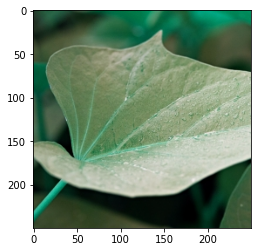

In [ ]:
import matplotlib.pyplot as plt
img = cv2.imread('/content/pot1.jpeg')
plt.imshow(img)
print(img.shape)

In [ ]:
l = ypr[1][0]
l

array([0.49312115, 0.4969399 , 0.8833267 , 0.90284914], dtype=float32)

In [ ]:
x1 = int(round((l[0]-l[2]/2)*img.shape[1]))
x2 = int(round((l[0]+l[2]/2)*img.shape[1]))
y1 = int(round((l[1]-l[3]/2)*img.shape[0]))
y2 = int(round((l[1]+l[3]/2)*img.shape[0]))

In [ ]:
x2

234

In [ ]:
cv2.rectangle(img,(x1,y1),(x2,y2),(256,256,256),1)

array([[[ 35,  57,  39],
        [ 36,  60,  42],
        [ 38,  63,  43],
        ...,
        [  1, 143,  96],
        [  5, 145,  98],
        [  3, 143,  96]],

       [[ 37,  58,  43],
        [ 38,  60,  42],
        [ 37,  61,  43],
        ...,
        [  0, 142,  95],
        [  3, 143,  96],
        [  3, 143,  96]],

       [[ 37,  55,  42],
        [ 37,  58,  43],
        [ 38,  61,  46],
        ...,
        [  1, 141,  94],
        [  1, 142,  93],
        [  1, 142,  93]],

       ...,

       [[ 54,  74,  45],
        [ 52,  72,  43],
        [ 56,  73,  46],
        ...,
        [ 71,  89,  60],
        [ 70,  90,  61],
        [ 69,  89,  60]],

       [[ 54,  76,  48],
        [ 56,  75,  48],
        [ 58,  75,  48],
        ...,
        [ 69,  90,  58],
        [ 68,  89,  57],
        [ 67,  90,  58]],

       [[ 55,  77,  49],
        [ 55,  77,  49],
        [ 58,  75,  48],
        ...,
        [ 67,  88,  56],
        [ 65,  88,  56],
        [ 65,  88,  56]]

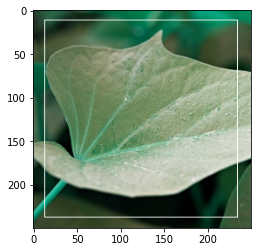

In [ ]:
plt.imshow(img)